<a href="https://colab.research.google.com/github/No0bDarren/ADALL_github/blob/main/ADALL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 - Load data + quick profiling

In [ ]:
import pandas as pd
from pathlib import Path

data_path = Path(r"C:\Users\darre\Desktop\Python\School Project\diabetes_012_health_indicators_BRFSS2015.csv")
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print("Missing values:\n", df.isna().sum())
print("Target counts:\n", df["Diabetes_012"].value_counts().sort_index())
print("Target %:\n", (df["Diabetes_012"].value_counts(normalize=True).sort_index() * 100).round(2))

Shape: (253680, 22)
Missing values:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Target counts:
 Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64
Target %:
 Diabetes_012
0.0    84.24
1.0     1.83
2.0    13.93
Name: proportion, dtype: float64


## Step 2 - Basic EDA (distributions + class balance)

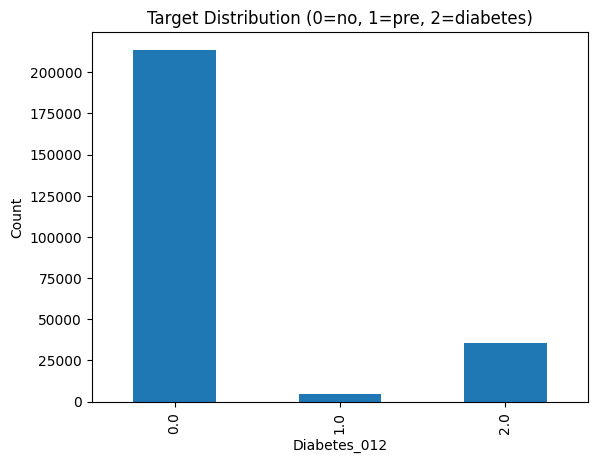

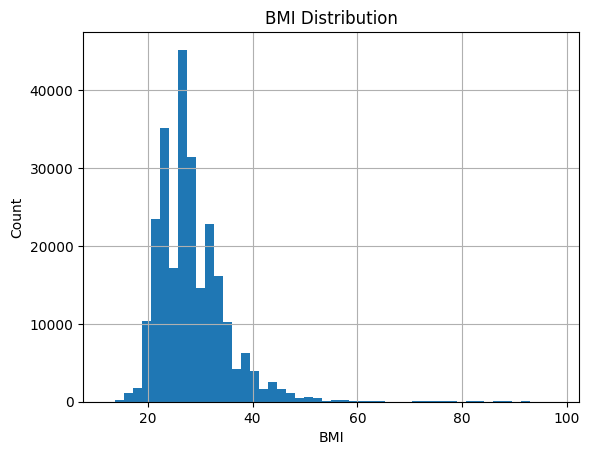

In [ ]:
import matplotlib.pyplot as plt

# Target distribution
ax = df["Diabetes_012"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target Distribution (0=no, 1=pre, 2=diabetes)")
ax.set_xlabel("Diabetes_012")
ax.set_ylabel("Count")
plt.show()

# BMI distribution
ax = df["BMI"].hist(bins=50)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()

## Step 3 - Train/test split (stratified)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

# 70/15/15 split (train/val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Feature engineering: Age group (>=40 vs <40)
# Age is ordinal bins; treat Age >= 8 as approx >= 40 years
for _df in (X_train, X_val, X_test):
    _df["AgeOver40"] = (_df["Age"] >= 8).astype(int)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (177576, 22)
Val shape: (38052, 22)
Test shape: (38052, 22)


## Step 3b - Preprocessing (log transform skewed + preserve ordinal order)


In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Skewed continuous features (right-skew)
skewed_cols = ["BMI", "MentHlth", "PhysHlth"]

# Ordinal features are kept as ordered numeric codes
ordinal_cols = ["Age", "Education", "Income", "GenHlth"]

preprocess = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), skewed_cols),
    ],
    remainder="passthrough"
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p = preprocess.transform(X_val)
X_test_p = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_p_df = pd.DataFrame(X_train_p, columns=feature_names)
X_val_p_df = pd.DataFrame(X_val_p, columns=feature_names)
X_test_p_df = pd.DataFrame(X_test_p, columns=feature_names)

print("Transformed shape:", X_train_p_df.shape)
print("Example transformed columns:", list(feature_names)[:10])


Transformed shape: (177576, 22)
Example transformed columns: ['log__BMI', 'log__MentHlth', 'log__PhysHlth', 'remainder__HighBP', 'remainder__HighChol', 'remainder__CholCheck', 'remainder__Smoker', 'remainder__Stroke', 'remainder__HeartDiseaseorAttack', 'remainder__PhysActivity']


## Step 3d - Identify categorical indices for SMOTENC


In [ ]:
# SMOTENC needs categorical feature indices in the post-preprocess matrix
continuous_cols = ["BMI", "MentHlth", "PhysHlth"]
categorical_cols = [c for c in X_train.columns if c not in continuous_cols]

cat_idx = []
for i, f in enumerate(feature_names):
    base_col = f.split("__", 1)[-1]
    if base_col in categorical_cols:
        cat_idx.append(i)

print("SMOTENC categorical feature count:", len(cat_idx))


SMOTENC categorical feature count: 19


## Step 3e - Balance training set with SMOTENC (synthetic data)


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTENC

print("Class counts before SMOTENC:", Counter(y_train))

# Oversample minority classes up to class 2 count (24,742)
target_c2 = 24742
sampling_target = {1: target_c2, 2: target_c2}
smotenc = SMOTENC(
    categorical_features=cat_idx,
    random_state=42,
    k_neighbors=1,
    sampling_strategy=sampling_target,
)
X_train_sm, y_train_sm = smotenc.fit_resample(X_train_p_df, y_train)

print("Class counts after SMOTENC:", Counter(y_train_sm))


Class counts before SMOTENC: Counter({0.0: 149592, 2.0: 24742, 1.0: 3242})
Class counts after SMOTENC: Counter({0.0: 149592, 2.0: 24742, 1.0: 24742})


## Step 3f - Transformation impact (macro F1: raw vs log)


In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Raw (no log transform) baseline
scaler_raw = StandardScaler()
X_train_raw_s = scaler_raw.fit_transform(X_train)
X_val_raw_s = scaler_raw.transform(X_val)

logreg_raw = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_raw.fit(X_train_raw_s, y_train)
raw_preds = logreg_raw.predict(X_val_raw_s)
raw_f1 = f1_score(y_val, raw_preds, average="macro")

# Log-transformed baseline (uses preprocess outputs)
scaler_log = StandardScaler()
X_train_log_s = scaler_log.fit_transform(X_train_p)
X_val_log_s = scaler_log.transform(X_val_p)

logreg_log = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_log.fit(X_train_log_s, y_train)
log_preds = logreg_log.predict(X_val_log_s)
log_f1 = f1_score(y_val, log_preds, average="macro")

print(f"Macro-F1 (raw): {raw_f1:.4f}")
print(f"Macro-F1 (log): {log_f1:.4f}")
print(f"Delta (log - raw): {log_f1 - raw_f1:.4f}")

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro-F1 (raw): 0.3919
Macro-F1 (log): 0.3957
Delta (log - raw): 0.0038


## Step 4 - Baseline model pipeline (Logistic Regression)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_p)
X_val_s = scaler.transform(X_val_p)
X_test_s = scaler.transform(X_test_p)

# Keep DataFrame versions so SHAP/plots show real column names
X_train_s_df = pd.DataFrame(X_train_s, columns=feature_names, index=X_train.index)
X_val_s_df = pd.DataFrame(X_val_s, columns=feature_names, index=X_val.index)
X_test_s_df = pd.DataFrame(X_test_s, columns=feature_names, index=X_test.index)

baseline = LogisticRegression(max_iter=1000, multi_class="auto")
baseline.fit(X_train_s_df, y_train)


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'auto'


## Step 5 - Evaluate baseline

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = baseline.predict(X_val_s)

print("Validation report (baseline):")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))


Validation report (baseline):
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.53      0.18      0.27      5302

    accuracy                           0.85     38052
   macro avg       0.46      0.39      0.40     38052
weighted avg       0.80      0.85      0.81     38052

[[31274     0   782]
 [  606     0    88]
 [ 4335     0   967]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-p

## Step 6 - Second model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Baseline RF on imbalanced data
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train_p_df, y_train)

y_val_pred_rf = rf.predict(X_val_p_df)
print("Validation report (RandomForest baseline, imbalanced)")
print(classification_report(y_val, y_val_pred_rf))


Validation report (RandomForest baseline, imbalanced)
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.48      0.16      0.24      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.38      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 6b - Third model (XGBoost)


In [ ]:
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost not installed. Install with: pip install xgboost") from e

# Baseline XGB on imbalanced data
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_p_df, y_train)
y_val_pred_xgb = xgb.predict(X_val_p_df)
print("Validation report (XGBoost baseline, imbalanced)")
print(classification_report(y_val, y_val_pred_xgb))


Validation report (XGBoost baseline, imbalanced)
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.57      0.19      0.28      5302

    accuracy                           0.85     38052
   macro avg       0.48      0.39      0.40     38052
weighted avg       0.81      0.85      0.81     38052



c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 7 - GridSearch tuning

In [ ]:
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def up_to_class2(y):
    counts = Counter(y)
    target = counts.get(2, max(counts.values()))
    return {cls: target for cls, n in counts.items() if n < target}

rf_pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smotenc", SMOTENC(
        categorical_features=cat_idx,
        random_state=42,
        k_neighbors=1,
        sampling_strategy=up_to_class2,
    )),
    ("rf", RandomForestClassifier(random_state=42)),
])

rf_param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [5, 10, None],
    "rf__min_samples_split": [2, 5],
    "rf__class_weight": ["balanced"],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("RF+SMOTENC best params:", rf_grid.best_params_)
print("Validation report (RF+SMOTENC CV best):")
print(classification_report(y_val, best_rf.predict(X_val)))


RF+SMOTENC best params: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 400}
Validation report (RF+SMOTENC CV best):
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90     32056
         1.0       0.01      0.00      0.00       694
         2.0       0.44      0.36      0.40      5302

    accuracy                           0.83     38052
   macro avg       0.45      0.43      0.44     38052
weighted avg       0.81      0.83      0.82     38052



## Step 7b - CV tuning for Logistic Regression and XGBoost


In [ ]:
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Logistic Regression CV
logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class="auto"),
    param_grid={"C": [0.1, 1.0, 3.0], "class_weight": [None, "balanced"]},
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
)
logreg_grid.fit(X_train_s, y_train)
best_logreg = logreg_grid.best_estimator_
print("Best LogReg params:", logreg_grid.best_params_)

try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost not installed. Install with: pip install xgboost") from e

def up_to_class2(y):
    counts = Counter(y)
    target = counts.get(2, max(counts.values()))
    return {cls: target for cls, n in counts.items() if n < target}

xgb_pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smotenc", SMOTENC(
        categorical_features=cat_idx,
        random_state=42,
        k_neighbors=1,
        sampling_strategy=up_to_class2,
    )),
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
    )),
])

xgb_param_grid = {
    "xgb__n_estimators": [200, 300],
    "xgb__max_depth": [3, 4],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8],
    "xgb__colsample_bytree": [0.8],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_grid = GridSearchCV(xgb_pipe, xgb_param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_)

print("Validation report (LogReg CV best):")
print(classification_report(y_val, best_logreg.predict(X_val_s)))
print("Validation report (XGBoost+SMOTENC CV best):")
print(classification_report(y_val, best_xgb.predict(X_val)))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LogReg params: {'C': 0.1, 'class_weight': 'balanced'}
Best XGB params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Validation report (LogReg CV best):
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     32056
         1.0       0.03      0.32      0.06       694
         2.0       0.36      0.60      0.45      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.53      0.43     38052
weighted avg       0.85      0.64      0.72     38052

Validation report (XGBoost+SMOTENC CV best):
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32056
         1.0       0.04      0.01      0.01       694
         2.0       0.57      0.18      0.27      5302

    accuracy                           0.85     38052
   macro avg       0.49      0.39      0.40     38052
weighted

## Step 8 - Explainability (feature importance)

In [ ]:
import pandas as pd

# Feature importance from the RF step in the pipeline
rf_step = best_rf.named_steps["rf"]
feat_names = best_rf.named_steps["preprocess"].get_feature_names_out()
importances = pd.Series(rf_step.feature_importances_, index=feat_names).sort_values(ascending=False)
print(importances.head(10))


log__BMI                0.195230
remainder__Age          0.113328
remainder__Income       0.092566
log__PhysHlth           0.085082
remainder__GenHlth      0.071449
log__MentHlth           0.069047
remainder__Education    0.063809
remainder__HighBP       0.037422
remainder__Smoker       0.032536
remainder__Fruits       0.032436
dtype: float64


## Step 10 - What-if analysis (sensitivity)

In [ ]:
# Adjust BMI for a single sample and see prediction changes
# best_rf is a pipeline (preprocess -> SMOTENC -> RF) and expects raw feature columns
sample = X_test.iloc[[0]].copy()

for bmi in [25, 30, 35, 40]:
    sample["BMI"] = bmi
    print("BMI:", bmi, "Pred:", best_rf.predict(sample)[0])


BMI: 25 Pred: 0.0
BMI: 30 Pred: 0.0
BMI: 35 Pred: 0.0
BMI: 40 Pred: 0.0


## Step 11 - Model comparison table (accuracy, macro F1, weighted F1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

models = {
    "LogReg_CV": (best_logreg, X_val_s_df),
    "RandomForest_CV": (best_rf, X_val),
    "XGBoost_CV": (best_xgb, X_val),
}

rows = []
for name, (model, X_model) in models.items():
    preds = model.predict(X_model)
    rows.append({
        "model": name,
        "accuracy_val": accuracy_score(y_val, preds),
        "f1_macro_val": f1_score(y_val, preds, average="macro"),
        "f1_weighted_val": f1_score(y_val, preds, average="weighted"),
        "recall_1": recall_score(y_val, preds, labels=[1], average=None)[0],
        "recall_2": recall_score(y_val, preds, labels=[2], average=None)[0],
    })

comparison = pd.DataFrame(rows).sort_values(by="f1_macro_val", ascending=False).reset_index(drop=True)
comparison


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,model,accuracy_val,f1_macro_val,f1_weighted_val,recall_1,recall_2
0,RandomForest_CV,0.829155,0.435419,0.816891,0.002882,0.363448
1,LogReg_CV,0.643646,0.428575,0.719323,0.321326,0.599208
2,XGBoost_CV,0.849574,0.400047,0.811326,0.005764,0.178235


## Step 11a - Final model selection (validation table)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Map each model to the correct validation features
models = {
    "LogReg_CV": (best_logreg, X_val_s_df),
    "RandomForest_CV": (best_rf, X_val),
    "XGBoost_CV": (best_xgb, X_val),
}

# Rule: highest Prediabetes recall (recall_1), tie-break with macro-F1
winner_name = comparison.sort_values(
    by=["recall_1", "f1_macro_val"], ascending=False
).iloc[0]["model"]
final_model, X_eval = models[winner_name]

print("FINAL MODEL (by recall_1):", winner_name)
print(comparison.sort_values(by=["recall_1", "f1_macro_val"], ascending=False).head(3))

# Validation metrics for selected final model
y_pred_val = final_model.predict(X_eval)
print("Final model validation classification report:")
print(classification_report(y_val, y_pred_val, digits=3))
print("Final model validation confusion matrix:")
print(confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2]))


FINAL MODEL (by recall_1): LogReg_CV
             model  accuracy_val  f1_macro_val  f1_weighted_val  recall_1  \
1        LogReg_CV      0.643646      0.428575         0.719323  0.321326   
2       XGBoost_CV      0.849574      0.400047         0.811326  0.005764   
0  RandomForest_CV      0.829155      0.435419         0.816891  0.002882   

   recall_2  
1  0.599208  
2  0.178235  
0  0.363448  
Final model validation classification report:
              precision    recall  f1-score   support

         0.0      0.952     0.658     0.778     32056
         1.0      0.031     0.321     0.057       694
         2.0      0.361     0.599     0.450      5302

    accuracy                          0.644     38052
   macro avg      0.448     0.526     0.429     38052
weighted avg      0.853     0.644     0.719     38052

Final model validation confusion matrix:
[[21092  5624  5340]
 [  178   223   293]
 [  884  1241  3177]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 11b - Top drivers summary (for insights write-up)

In [ ]:
# Top drivers summary aligned with final selected model
import pandas as pd
import numpy as np
import shap

sample_n = 120

if winner_name.startswith("LogReg"):
    X_shap = X_eval.iloc[:sample_n]
    background = X_train_s_df.sample(n=min(200, len(X_train_s_df)), random_state=42)
    explainer = shap.LinearExplainer(final_model, background)
    shap_values = explainer(X_shap)

    sv = shap_values[..., 1] if np.ndim(shap_values.values) == 3 else shap_values
    feat_names = list(X_shap.columns)
    shap_abs = np.abs(sv.values).mean(axis=0)
    shap_top = pd.Series(shap_abs, index=feat_names).sort_values(ascending=False).head(5)
    print("Top SHAP features (LogReg, class 1):\n", shap_top)
else:
    model = final_model.named_steps["rf"] if "rf" in final_model.named_steps else final_model.named_steps["xgb"]
    X_proc = final_model.named_steps["preprocess"].transform(X_eval)
    X_shap = X_proc[:sample_n]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_shap)

    sv = shap_values[..., 1] if np.ndim(shap_values.values) == 3 else shap_values
    feat_names = final_model.named_steps["preprocess"].get_feature_names_out()
    shap_abs = np.abs(sv.values).mean(axis=0)
    shap_top = pd.Series(shap_abs, index=feat_names).sort_values(ascending=False).head(5)
    print("Top SHAP features (Tree, class 1):\n", shap_top)


Top SHAP features (LogReg, class 1):
 remainder__Age         0.119908
remainder__HighChol    0.092829
log__BMI               0.067974
remainder__Income      0.041638
log__MentHlth          0.040669
dtype: float64


## Step 12 - Error analysis (final model)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

if 'final_model' not in globals() or 'X_eval' not in globals():
    raise RuntimeError("final_model is not defined yet. Run Step 11 (comparison) and Step 11a (FINAL MODEL) before running error analysis.")

y_pred_best = final_model.predict(X_eval)
cm = confusion_matrix(y_val, y_pred_best, labels=[0, 1, 2])
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print(classification_report(y_val, y_pred_best, digits=3))

# Ensure tabular frame for profile diagnostics
if hasattr(X_eval, "columns"):
    errors = X_eval.copy()
else:
    errors = pd.DataFrame(X_eval, columns=feature_names)

errors["true"] = y_val.values
errors["pred"] = y_pred_best
misclassified = errors[errors["true"] != errors["pred"]]
correct = errors[errors["true"] == errors["pred"]]

# Use the columns that actually exist (raw for pipelines, preprocessed for arrays)
feature_cols = [c for c in errors.columns if c not in ["true", "pred"]]
mis_means = misclassified[feature_cols].mean(numeric_only=True)
cor_means = correct[feature_cols].mean(numeric_only=True)
diff = (mis_means - cor_means).abs().sort_values(ascending=False)
print("Top feature differences (misclassified vs correct):")
print(diff.head(10))


Confusion matrix (rows=true, cols=pred):
 [[21092  5624  5340]
 [  178   223   293]
 [  884  1241  3177]]
              precision    recall  f1-score   support

         0.0      0.952     0.658     0.778     32056
         1.0      0.031     0.321     0.057       694
         2.0      0.361     0.599     0.450      5302

    accuracy                          0.644     38052
   macro avg      0.448     0.526     0.429     38052
weighted avg      0.853     0.644     0.719     38052

Top feature differences (misclassified vs correct):
remainder__GenHlth      0.770697
remainder__HighBP       0.757403
remainder__Age          0.737517
remainder__HighChol     0.729249
remainder__AgeOver40    0.616914
remainder__Income       0.578864
log__BMI                0.547976
remainder__Education    0.453084
remainder__DiffWalk     0.430733
log__PhysHlth           0.384570
dtype: float64


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 13 - Permutation Feature Importance (pFI)

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

perm = permutation_importance(
    final_model, X_eval, y_val,
    n_repeats=5, random_state=42, scoring="f1_macro"
)

# Use raw column names when X_eval is a DataFrame
if hasattr(X_eval, "columns"):
    feat_names = list(X_eval.columns)
else:
    feat_names = list(feature_names)

importances = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print(importances.head(10))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but

remainder__GenHlth                 0.033617
log__BMI                           0.018730
remainder__HighBP                  0.016433
remainder__Age                     0.003431
remainder__AgeOver40               0.003229
remainder__HvyAlcoholConsump       0.002849
remainder__CholCheck               0.001728
remainder__Income                  0.001705
remainder__HeartDiseaseorAttack    0.001090
remainder__DiffWalk                0.001048
dtype: float64


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 14 - SHAP (global + local explainability)

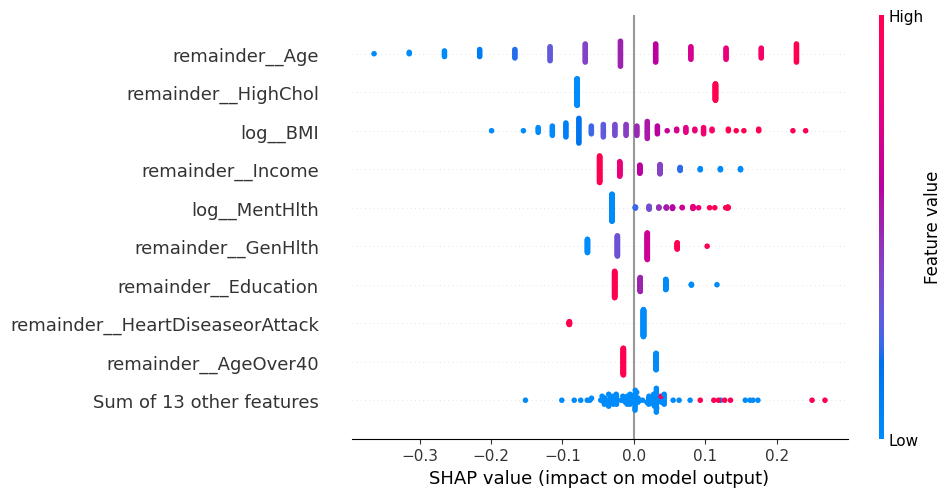

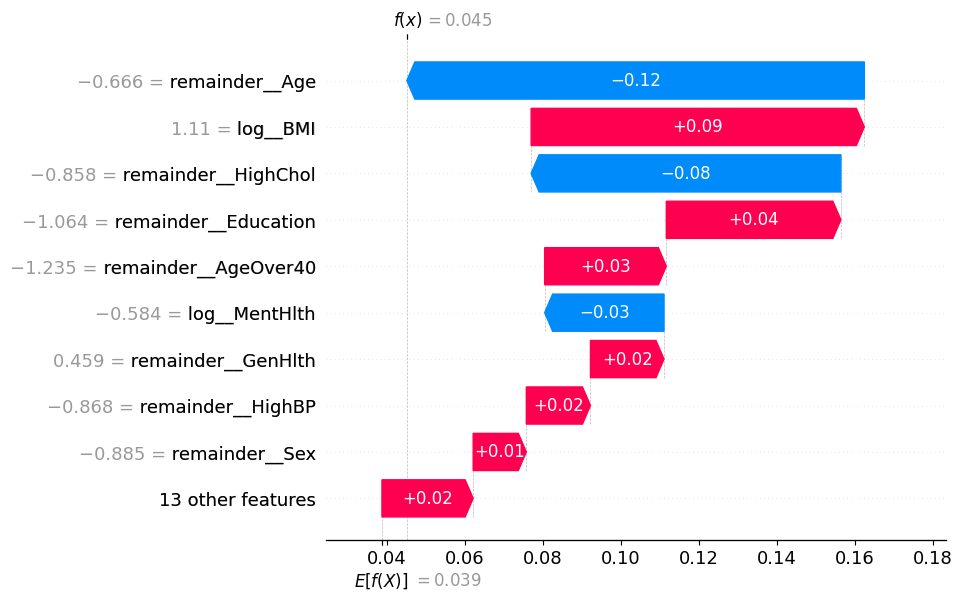

In [ ]:
try:
    import shap
except ImportError as e:
    raise ImportError("shap not installed. Install with: pip install shap") from e

import numpy as np

sample_n = 120

if winner_name.startswith("LogReg"):
    X_shap = X_eval.iloc[:sample_n]
    background = X_train_s_df.sample(n=min(200, len(X_train_s_df)), random_state=42)
    explainer = shap.LinearExplainer(final_model, background)
    shap_values = explainer(X_shap)
    sv = shap_values[..., 1] if np.ndim(shap_values.values) == 3 else shap_values

    shap.plots.beeswarm(sv)
    shap.plots.waterfall(sv[0])
else:
    model = final_model.named_steps["rf"] if "rf" in final_model.named_steps else final_model.named_steps["xgb"]
    X_proc = final_model.named_steps["preprocess"].transform(X_eval)
    X_shap = X_proc[:sample_n]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_shap)
    sv = shap_values[..., 1] if np.ndim(shap_values.values) == 3 else shap_values

    shap.plots.beeswarm(sv)
    shap.plots.waterfall(sv[0])


## Step 16 - Class-weighted models (optimize class-1 recall)

In [ ]:
from sklearn.metrics import classification_report

# Class-weighted Logistic Regression
logreg_cw = LogisticRegression(max_iter=1000, multi_class="auto", class_weight="balanced")
logreg_cw.fit(X_train_s, y_train)
logreg_cw_preds = logreg_cw.predict(X_val_s)
print("Validation report (LogReg class_weight=balanced)")
print(classification_report(y_val, logreg_cw_preds))

# Class-weighted Random Forest
rf_cw = RandomForestClassifier(
    n_estimators=400, random_state=42, class_weight="balanced"
)
rf_cw.fit(X_train_p_df, y_train)
rf_cw_preds = rf_cw.predict(X_val_p_df)
print("Validation report (RandomForest class_weight=balanced)")
print(classification_report(y_val, rf_cw_preds))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation report (LogReg class_weight=balanced)
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     32056
         1.0       0.03      0.32      0.06       694
         2.0       0.36      0.60      0.45      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.53      0.43     38052
weighted avg       0.85      0.64      0.72     38052

Validation report (RandomForest class_weight=balanced)
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.48      0.16      0.24      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.38      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 17 - SMOTENC + model training (focus on class-1 recall)


In [ ]:
from sklearn.metrics import classification_report

# Train RF on SMOTENC data from Step 3e
rf_sm = RandomForestClassifier(n_estimators=400, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
rf_sm_preds = rf_sm.predict(X_val_p_df)
print("Validation report (RandomForest + SMOTENC)")
print(classification_report(y_val, rf_sm_preds))


Validation report (RandomForest + SMOTENC)
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32056
         1.0       0.02      0.00      0.00       694
         2.0       0.49      0.18      0.26      5302

    accuracy                           0.84     38052
   macro avg       0.46      0.38      0.39     38052
weighted avg       0.80      0.84      0.81     38052



## Step 18 - Precision-Recall curve + threshold tuning for class 1

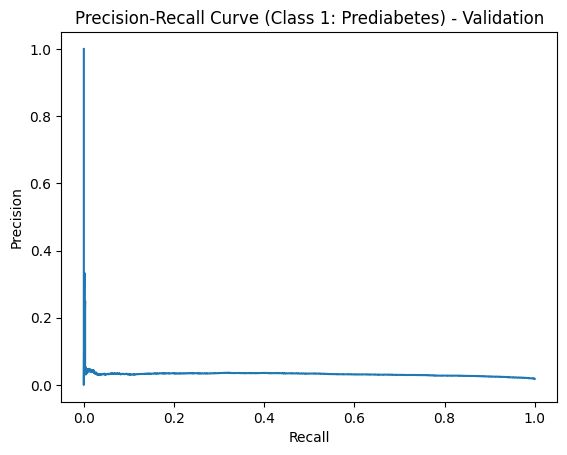

Selected threshold: 0.07316047
Validation report (XGBoost threshold-tuned for class 1)
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     32056
         1.0       0.03      0.61      0.05       694
         2.0       0.57      0.18      0.27      5302

    accuracy                           0.57     38052
   macro avg       0.51      0.47      0.36     38052
weighted avg       0.87      0.57      0.67     38052



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Tune threshold on validation only (XGBoost pipeline)
probs = best_xgb.predict_proba(X_val)
class1_probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve((y_val == 1).astype(int), class1_probs)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Class 1: Prediabetes) - Validation")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

valid_idx = np.where(recall >= 0.70)[0]
if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(precision[valid_idx])]
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    print("Selected threshold:", best_thresh)
else:
    best_thresh = 0.5
    print("Fallback threshold:", best_thresh)

preds = best_xgb.predict(X_val)
preds_tuned_val = preds.copy()
mask = (preds == 0) & (class1_probs >= best_thresh)
preds_tuned_val[mask] = 1

print("Validation report (XGBoost threshold-tuned for class 1)")
print(classification_report(y_val, preds_tuned_val))


## Step 19 - Consolidated model tracking (accuracy, macro-F1, class-1 recall, class-2 recall)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

rows = []

def add_row(name, model, X_model, y_eval, tuned_preds=None):
    preds = tuned_preds if tuned_preds is not None else model.predict(X_model)
    rows.append({
        "model": name,
        "accuracy_val": accuracy_score(y_eval, preds),
        "f1_macro_val": f1_score(y_eval, preds, average="macro"),
        "recall_c1_val": recall_score(y_eval, preds, labels=[1], average=None)[0],
        "recall_c2_val": recall_score(y_eval, preds, labels=[2], average=None)[0],
    })

add_row("LogReg_CV", best_logreg, X_val_s, y_val)
add_row("RandomForest_CV", best_rf, X_val, y_val)
add_row("XGBoost_CV", best_xgb, X_val, y_val)
add_row("LogReg_class_weight", logreg_cw, X_val_s, y_val)
add_row("RF_class_weight", rf_cw, X_val_p_df, y_val)
add_row("RF_SMOTENC", rf_sm, X_val_p_df, y_val)
add_row("XGB_threshold_tuned", best_xgb, X_val, y_val, tuned_preds=preds_tuned_val)

tracking = pd.DataFrame(rows).sort_values(by=["recall_c1_val", "f1_macro_val"], ascending=False).reset_index(drop=True)
tracking


,model,accuracy_val,f1_macro_val,recall_c1_val,recall_c2_val
0,XGB_threshold_tuned,0.565489,0.359599,0.610951,0.178235
1,LogReg_CV,0.643646,0.428575,0.321326,0.599208
2,LogReg_class_weight,0.643619,0.428536,0.321326,0.599019
3,XGBoost_CV,0.849574,0.400047,0.005764,0.178235
4,RandomForest_CV,0.829155,0.435419,0.002882,0.363448
5,RF_SMOTENC,0.840692,0.393528,0.002882,0.180121
6,RF_class_weight,0.839824,0.383513,0.000000,0.158808


## Step 20 - Final test evaluation (holdout)

Run once after selecting the final model in Step 11a.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate final model once on test set
if winner_name.startswith("LogReg"):
    X_test_final = X_test_s_df
else:
    X_test_final = X_test

y_final_pred = final_model.predict(X_test_final)
print("Final test classification report (one-time holdout):")
print(classification_report(y_test, y_final_pred, digits=3))
print("Final test confusion matrix:")
print(confusion_matrix(y_test, y_final_pred, labels=[0, 1, 2]))


Final test classification report (one-time holdout):
              precision    recall  f1-score   support

         0.0      0.952     0.660     0.779     32055
         1.0      0.030     0.298     0.054       695
         2.0      0.355     0.594     0.444      5302

    accuracy                          0.644     38052
   macro avg      0.445     0.517     0.426     38052
weighted avg      0.852     0.644     0.719     38052

Final test confusion matrix:
[[21151  5482  5422]
 [  190   207   298]
 [  884  1269  3149]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 21 - Retrain final model on train+val (optional, production-style)

Refit the chosen model on train+val, then evaluate once on test.


In [ ]:
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix

# Combine train + val
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
X_trainval_s_df = pd.concat([X_train_s_df, X_val_s_df], axis=0)

# Choose the right feature space based on model type
if winner_name.startswith("LogReg"):
    X_fit = X_trainval_s_df
    X_test_final = X_test_s_df
else:
    X_fit = X_trainval
    X_test_final = X_test

final_model_retrained = clone(final_model)
final_model_retrained.fit(X_fit, y_trainval)

y_final_retrained = final_model_retrained.predict(X_test_final)
print("Retrained final model test report:")
print(classification_report(y_test, y_final_retrained, digits=3))
print("Retrained final model confusion matrix:")
print(confusion_matrix(y_test, y_final_retrained, labels=[0, 1, 2]))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Retrained final model test report:
              precision    recall  f1-score   support

         0.0      0.952     0.664     0.782     32055
         1.0      0.031     0.308     0.057       695
         2.0      0.354     0.593     0.443      5302

    accuracy                          0.647     38052
   macro avg      0.446     0.521     0.427     38052
weighted avg      0.852     0.647     0.722     38052

Retrained final model confusion matrix:
[[21269  5347  5439]
 [  188   214   293]
 [  886  1273  3143]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


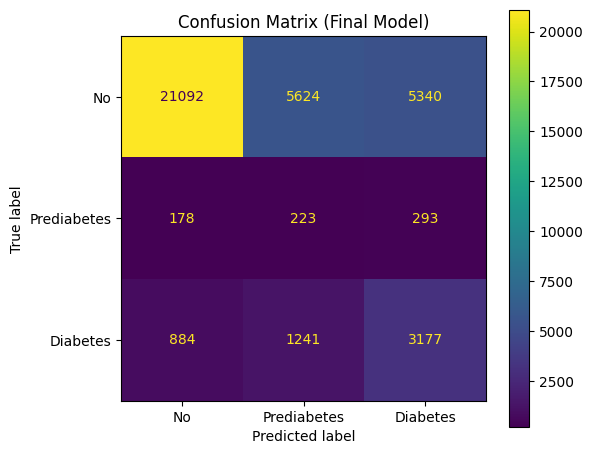

              precision    recall  f1-score   support

          No       0.95      0.66      0.78     32056
 Prediabetes       0.03      0.32      0.06       694
    Diabetes       0.36      0.60      0.45      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.53      0.43     38052
weighted avg       0.85      0.64      0.72     38052



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

if 'final_model' not in globals() or 'X_eval' not in globals():
    raise RuntimeError("Run Step 11 and Step 11a first so final_model and X_eval are defined.")

labels = [0, 1, 2]
label_names = ["No", "Prediabetes", "Diabetes"]

# Validation target aligned with X_eval
y_eval = y_val
y_pred = final_model.predict(X_eval)

cm = confusion_matrix(y_eval, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix (Final Model)")
plt.tight_layout()
plt.savefig("cm_final.png", dpi=200)
plt.show()

print(classification_report(y_eval, y_pred, target_names=label_names))


## Step 22 - Diabetes risk thresholds from predicted probability


In [ ]:
import numpy as np

if 'final_model' not in globals() or 'X_eval' not in globals():
    raise RuntimeError("Run Step 11 and Step 11a first so final_model and X_eval are defined.")
if not hasattr(final_model, 'predict_proba'):
    raise RuntimeError("Selected final_model has no predict_proba().")

proba = final_model.predict_proba(X_eval)
p_diabetes = proba[:, 2]  # class 2 probability

high_thr = np.quantile(p_diabetes, 0.90)  # top 10% as High
med_thr = np.quantile(p_diabetes, 0.70)   # next 20% as Medium

print('High threshold:', high_thr)
print('Medium threshold:', med_thr)


High threshold: 0.5033426643316642
Medium threshold: 0.3382376401175759


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 23 - Assign risk tiers (High/Medium/Low)


In [ ]:
import pandas as pd

if 'p_diabetes' not in globals() or 'high_thr' not in globals() or 'med_thr' not in globals():
    raise RuntimeError("Run Step 22 first to compute p_diabetes and thresholds.")

risk_tier = np.where(
    p_diabetes >= high_thr,
    'High',
    np.where(p_diabetes >= med_thr, 'Medium', 'Low')
)

risk_summary = pd.Series(risk_tier, name='risk_tier').value_counts().reindex(['High', 'Medium', 'Low'], fill_value=0)
risk_pct = (risk_summary / risk_summary.sum() * 100).round(2)

risk_table = pd.DataFrame({'count': risk_summary, 'percent': risk_pct})
risk_table


,count,percent
risk_tier,,
High,3806,10.0
Medium,7610,20.0
Low,26636,70.0
